In [1]:
import jax.numpy as jnp
import jax.lax as lax
import matplotlib.pyplot as plt



import numpy as np 
import pymaster as nmt
import healpy as hp
import gc
import time
from tqdm import tqdm
%matplotlib inline

In [2]:
def sample_in_gal_coord(n_points):
        '''The galactic latitude gb spans a range of [-90, 90]. 
        The galactic longitude gl spans a range of [0, 360]'''        
        
        phi, cos_theta = np.random.uniform([0, -1], [2*np.pi, 1], size = (n_points, 2)).T
    
        theta = np.pi/2 - np.arccos(cos_theta)
        
        gl = (phi*180)/np.pi
        gb = (theta*180)/np.pi
        
        
        return gl ,gb

In [3]:
n_samples = 1000

gl, gb = sample_in_gal_coord(n_samples)

sin_gl = np.sin(gl*np.pi/180)
cos_gl = np.cos(gl*np.pi/180)
sin_gb = np.sin(gb*np.pi/180)
cos_gb = np.cos(gb*np.pi/180)



cos_theta = sin_gb[None,:] * sin_gb[:, None] + cos_gb[None,:] * cos_gb[:, None] * np.cos(gl[None,:]*np.pi/180 - gl[:, None]*np.pi/180)

gc.collect()

4

In [4]:
nside = 256
lmin = 1
nell = 20
# edges = np.unique(np.geomspace(lmin,3*nside,nell).astype(int))
edges= np.arange(1, 3*nside + 1)
cl_DMDM = np.load("/home/s59efara_hpc/covariance/test_cl_kappadm.npy")[:, 0 ,0]
map = hp.synfast(cl_DMDM, nside=nside, lmax=cl_DMDM.shape[0]-1, new=True)
ipix = hp.ang2pix(nside, np.pi/2 - gb*np.pi/180, gl*np.pi/180)
w = np.ones_like(ipix)



# beware of the binning scheme and the values to be added to the  
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
# b = nmt.NmtBin.from_lmax_linear(3*nside - 1, nell)
f_vals = map[ipix] - np.mean(map[ipix])
f_nmt = nmt.NmtFieldCatalog(positions = [gl, gb], weights=w, field = f_vals, lmax=b.lmax, lonlat=True)
wasp = nmt.NmtWorkspace.from_fields(f_nmt, f_nmt, b)

Sl_coupled = nmt.compute_coupled_cell(f_nmt, f_nmt) # the coupled, noise subtracted power spectrum 
Nf = f_nmt.Nf
Cl = Sl_coupled + Nf 
Sl = wasp.decouple_cell(Sl_coupled)

Rl = Sl + Nf

In [5]:
ells = b.get_effective_ells()
npix = hp.nside2npix(nside)
f_sky = n_samples/npix
mcm = jnp.asarray(wasp.get_coupling_matrix())[1:, 1:]
mcm_inv = np.linalg.inv(mcm)

In [6]:
from scipy.integrate import simpson
field_variance = simpson(Sl*b.get_effective_ells(), x = b.get_effective_ells())/(2*np.pi)
Nw_sigma_s = field_variance*f_nmt.Nw
noise_variance = (simpson(Nf*b.get_effective_ells(), x = b.get_effective_ells())/2./np.pi)/n_samples
var_f = np.var(f_vals)


In [7]:
field_variance = np.sum((2*ells + 1)*Sl/4./np.pi)

In [8]:
w_ij_4pi = w[None, :]*w[:, None]/(4*np.pi)
mask_poles = jnp.where((cos_theta==1) | (cos_theta==-1))
w_ij_4pi[mask_poles[0], mask_poles[1]] = 0.

In [9]:
# Recurrence: (l+1) P_{l+1} = (2l+1)x P_l - l P_{l-1}
def body_fn(carry, l):
    P_lm1, P_l = carry
    P_lp1 = ((2*l + 1)*cos_theta*P_l - l*P_lm1) / (l + 1)
    return (P_l, P_lp1), P_lp1

# Initialize P_0 = 1, P_1 = x
carry_init = (jnp.ones_like(cos_theta), cos_theta)

# Run scan from l=1 to Lmax-1
_, P_all = lax.scan(body_fn, carry_init, jnp.arange(2, edges[-1]))
P_all = jnp.concatenate([
    # jnp.ones_like(cos_theta)[None, :],   # P_0
    cos_theta[None, :],                  # P_1
    P_all                        # P_2 ... P_Lmax
], axis=0)

In [10]:
wP_aij = P_all*w_ij_4pi

In [11]:
term1_matrix = jnp.einsum('aij, bij->ab', wP_aij, wP_aij)

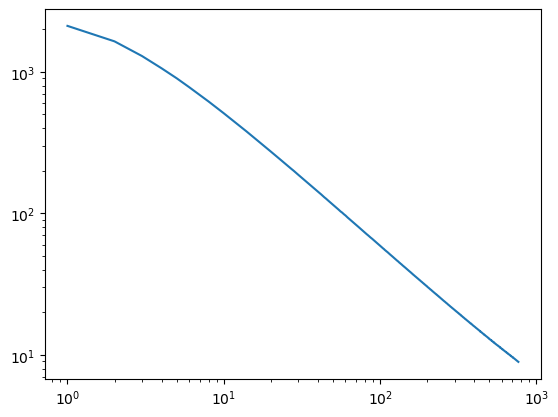

In [12]:
plt.loglog(np.arange(1, edges[-1]), jnp.diag(term1_matrix))

In [13]:
matrix_term = 2*term1_matrix*var_f**2
term1 = jnp.einsum('ka, lb, ab->kl', mcm_inv, mcm_inv, matrix_term)

(90.0, 1000.0)

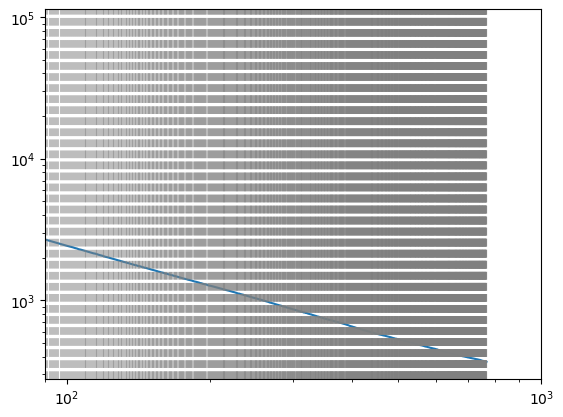

In [14]:
plt.loglog(jnp.arange(1, edges[-1]), jnp.diag(term1))
for i in ells:
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)#

plt.xlim(9e1, 1e3)

In [15]:
import numpy as np

def build_binning_matrix(edges, lmax):
    
    nbins = len(edges) - 1
    lmin = edges[0]
    B = np.zeros((nbins, lmax - lmin))
    ell_eff = np.zeros(nbins)

    for b in range(nbins):
        ell_min, ell_max = edges[b], edges[b + 1]
        if ell_min != ell_max - 1:
            ells_in_bin = np.arange(ell_min, ell_max)
            sum_w = np.sum(2*ells_in_bin + 1)
            for i in ells_in_bin:
                B[b, i - lmin] = (2*i + 1) / sum_w
                ell_eff[b] = np.mean(ells_in_bin)
        
                
    return B, ell_eff
Binning, ell_eff = build_binning_matrix(edges, edges[-1])
Binning = jnp.array(Binning)

In [16]:
def build_binning_matrix(edges, lmax):


    nbins = len(edges) - 1

    lmin = edges[0]

    B = np.zeros((nbins, lmax - lmin))

    ell_eff = np.zeros(nbins)



    for b in range(nbins):

        ell_min, ell_max = edges[b], edges[b + 1]

        ells_in_bin = np.arange(ell_min, ell_max)

        Δℓ = len(ells_in_bin)
    
        if Δℓ > 0:

            B[b, ells_in_bin - lmin] = 1.0 / Δℓ

            ell_eff[b] = np.mean(ells_in_bin)

    return B, ell_eff

Binning, ell_eff = build_binning_matrix(edges, edges[-1])

Binning = jnp.array(Binning)

In [17]:
field_variance_binned_cov = Binning @ term1 @ Binning.T

In [18]:
data = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_field_variance.npy')

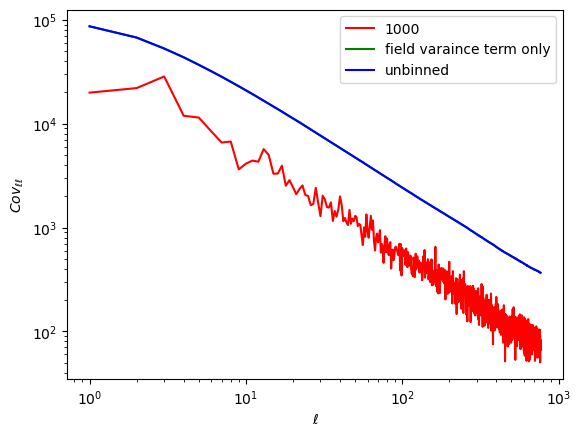

In [19]:
n_sources_list = np.array([1000], dtype=int)    


# fig, ax = plt.subplots(figsize = (12, 8))

for i in range(len(n_sources_list)):
    ls, cls, sigma, _, _ = data[i]
    plt.loglog(ls, sigma, label = n_sources_list[i], color = 'red')
    # sigma_th = (2*(clth_binned + 4*np.pi*field_variance/n_sources_list[i])**2)/(delta_ell*(2*ells + 1))
# plt.loglog(np.arange(0, edges[-1], 1), jnp.diag(Cov_N), label='full variance')

plt.loglog(ells, jnp.diag(field_variance_binned_cov), label='field varaince term only', color = 'green')


plt.loglog(jnp.arange(1, edges[-1]), jnp.diag(term1), label = 'unbinned', color = 'blue')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cov_{\ell \ell}$')
plt.legend()

# plt.savefig('covariance_comparison_cp
# cl_jax_nsource_1000.png', dpi = 300, bbox_inches='tight')

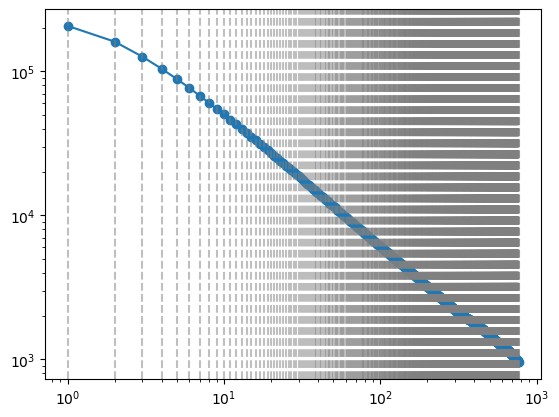

In [53]:
plt.scatter(ells, jnp.diag(field_variance_binned_cov))

plt.loglog(np.arange(1,edges[-1]), jnp.diag(term1))
for i in edges:
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

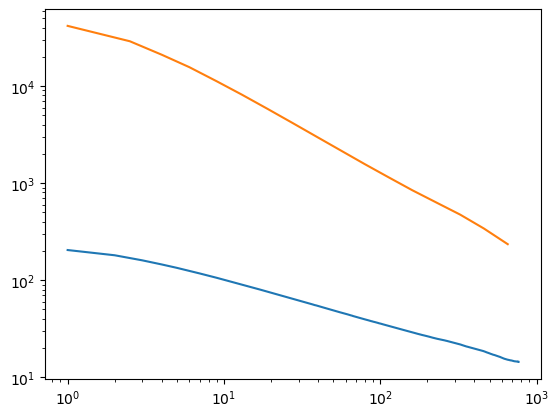

In [163]:
plt.loglog(jnp.arange(1, edges[-1]), jnp.sqrt(jnp.diag(term1)), label = 'unbinned')
plt.loglog(ells, Binning @ jnp.sqrt(jnp.diag(term1))* (Binning @ jnp.sqrt(jnp.diag(term1))))

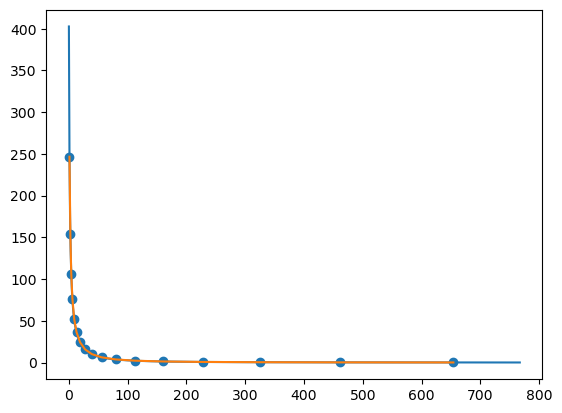

In [157]:
plt.plot(np.arange(edges[-1]), cl_DMDM[:edges[-1]])
Cl_th_binned = b.bin_cell(cl_DMDM[:edges[-1]])

plt.plot(ells, Cl_th_binned)
plt.scatter(ells, Binning @ cl_DMDM[1:edges[-1]])